## Notas de aula 25 de setembro

# Redes de Convolução

In [1]:
from PIL import Image
import skimage.measure 

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/Users/marcocristo/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
def reset_graph(seed = 42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
def plot_figs(lst):
    if len(lst) == 1:
        plt.matshow(lst[0], cmap = 'gray', interpolation = 'nearest')
    else:
        f, axes = plt.subplots(1, len(lst))
        for i, a in enumerate(axes):
            a.matshow(lst[i], cmap = 'gray', interpolation = 'nearest')
            a.set(aspect = 'equal')

In [4]:
# save and restore net in memory
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

### Convoluções

In [5]:
ex0 = np.array([[0,0,0,1,0,0,0,0],
                [0,0,1,0,0,0,0,0],
                [0,1,0,0,0,0,0,0],
                [1,0,0,0,0,0,0,0],
                [0,0,0,0,1,0,0,0],
                [0,0,0,0,0,1,0,0],
                [0,0,0,0,0,0,1,0],
                [0,0,0,0,0,0,0,1]], dtype=np.float32)
ex1 = np.array([[0,0,0,0,0,0,0,1],
                [0,0,0,0,0,0,0,1],
                [0,0,0,0,0,0,1,0],
                [0,0,0,0,0,0,1,0],
                [0,0,0,0,0,1,0,0],
                [0,0,0,0,0,1,0,0],
                [0,0,0,0,1,0,0,0],
                [0,0,0,0,1,0,0,0]], dtype=np.float32)
k0 = np.array([[0,0,0,1],
               [0,0,1,1],
               [0,0,1,0],
               [0,1,0,0]], dtype=np.float32)

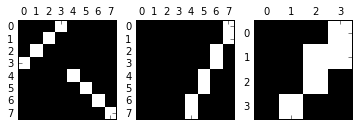

In [6]:
plot_figs([ex0, ex1, k0])

In [7]:
def conv0(a1, a2):
    sigmoid = lambda n: 1. / (1 + np.exp(-n))
    a1r = a1.reshape((-1, 1))
    a2r = a2.reshape((-1, 1))
    return sigmoid(np.sum(np.multiply(a1r, a2r)))

0.88079707933191798

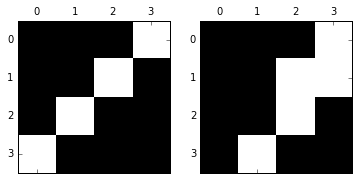

In [8]:
plot_figs([ex0[:4, :4], k0])
conv0(ex0[:4,:4], k0)

0.73105857373994898

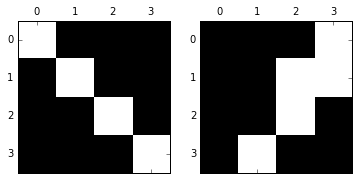

In [9]:
plot_figs([ex0[4:, 4:], k0])
conv0(ex0[4:,4:], k0)

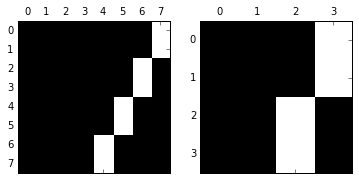

In [10]:
ex1p = skimage.measure.block_reduce(ex1, (2,2), np.max)
plot_figs([ex1, ex1p])

0.95257412817534082

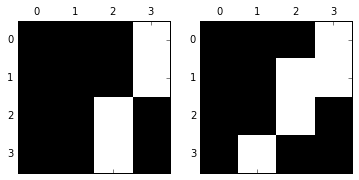

In [11]:
plot_figs([ex1p, k0])
conv0(ex1p, k0)

In [15]:
def tfconv(imgs, kernels):
    reset_graph()
    # X.shape = batches, alt, larg, canais de entrada
    X = tf.constant(imgs, dtype=tf.float32)
    feature_map = tf.constant(kernels)
    convolution = tf.nn.conv2d(X, feature_map,
                              strides = [1,1,1,1],
                              padding = 'SAME')
    with tf.Session() as s:
        output = convolution.eval()
    return output

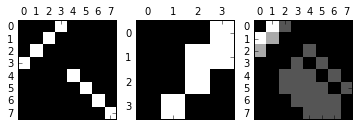

In [16]:
# fmap eh 1d -> alt, larg, canais de entrada, canais de saida
fmap = k0.reshape(k0.shape[0], k0.shape[1], 1, 1)
ex04d = ex0.reshape(1, ex0.shape[0], ex0.shape[1], 1)
output = tfconv(ex04d, fmap)
plot_figs([ex0, k0, output[0, :, :, 0]])

In [17]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('data/MNIST_data')

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [24]:
height = 28
width = 28
channels = 1
n_inputs = height * width

reset_graph()

with tf.name_scope('inputs'):
    X = tf.placeholder(tf.float32, shape=(None, n_inputs), name = 'X')
    X_reshaped = tf.reshape(X, shape=(-1, height, width, channels))
    y = tf.placeholder(tf.int32, shape = (None), name = 'y')
    
conv1 = tf.layers.conv2d(X_reshaped, filters = 8, kernel_size = 3,
                        strides = 1, padding = 'SAME',
                        activation = tf.nn.relu, name = 'conv1')

conv2 = tf.layers.conv2d(conv1, filters = 16, kernel_size = 3,
                        strides = 2, padding = 'SAME',
                        activation = tf.nn.relu, name = 'conv2')

with tf.name_scope('pool3'):
    pool3 = tf.nn.max_pool(conv2, ksize = [1,2,2,1],
                          strides = [1,2,2,1], padding = 'VALID')
    pool3_flat = tf.reshape(pool3, shape = (-1, 16*7*7))

with tf.name_scope('fc1'):
    fc1 = tf.layers.dense(pool3_flat, 64, 
                          activation = tf.nn.relu, name = 'fc1')
    
with tf.name_scope('output'):
    logits = tf.layers.dense(fc1, 10, name = 'output')
    Y_proba = tf.nn.softmax(logits, name = 'Y_proba')

with tf.name_scope('train'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits = logits, labels = y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
with tf.name_scope('init_and_save'):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [25]:
n_epochs = 10
batch_size = 100

with tf.Session() as s:
    init.run()
    for e in range(n_epochs):
        for i in range(mnist.train.num_examples // batch_size):
            X_b, y_b = mnist.train.next_batch(batch_size)
            s.run(training_op, feed_dict = {X: X_b, y: y_b})
        acc_tr = accuracy.eval(feed_dict = {X: X_b, y: y_b})
        acc_test = accuracy.eval(feed_dict = {X: mnist.test.images, 
                                              y: mnist.test.labels})
        print '%d: acc_tr: %.5f test: %.5f' % (e, acc_tr, acc_test)
        saver.save(s, '/tmp/mnist_1a_convnet')    

0: acc_tr: 0.96000 test: 0.95810
1: acc_tr: 0.98000 test: 0.97150
2: acc_tr: 0.96000 test: 0.97990
3: acc_tr: 0.99000 test: 0.98180
4: acc_tr: 1.00000 test: 0.98270
5: acc_tr: 0.97000 test: 0.98470
6: acc_tr: 1.00000 test: 0.98680
7: acc_tr: 0.99000 test: 0.98570
8: acc_tr: 1.00000 test: 0.98720
9: acc_tr: 1.00000 test: 0.98570
